This notebook uses corrected $R_{eff}$ estimation data from Tamas Ferenci, and combines it with latest Hungarian data
about number of confirmed cases and test positivity downloaded directly from the webpage of Tamas Ferenci
(which is downloaded from the Johns Hopkins dashboard).

In [1]:
from datetime import datetime, timedelta
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../")
from src.dataloader import PROJECT_PATH

In [2]:
plt.rcParams["font.size"] = 18

In [3]:
# reading r_eff estimation data from Tamas Ferenci
# institutional and imported cases are excluded in Spring and Summer 2020
# source: e-mailed by the author

ferenci_corrected = pd.read_csv(
    os.path.join(PROJECT_PATH, 'data/r_eff_estimations.csv'),
    sep=";",
    header=None,
    index_col=0
)

ferenci_corrected["date"] = ferenci_corrected[4]\
    .map(lambda i: (datetime(2020,3,3)+timedelta(days=i)).strftime('%Y-%m-%d'))
ferenci_corrected["r_eff"] = ferenci_corrected[1].map(lambda s: float(s.replace(',','.')))
ferenci_corrected["ci_lower"] = ferenci_corrected[2].map(lambda s: float(s.replace(',','.')))
ferenci_corrected["ci_upper"] = ferenci_corrected[3].map(lambda s: float(s.replace(',','.')))
ferenci_corrected["method"] = ferenci_corrected[5]
ferenci_corrected.drop([1,2,3,4,5],axis=1,inplace=True)

ferenci_corrected.head()

,date,r_eff,ci_lower,ci_upper,method
0,,,,,
1,2020-03-11,2.082500,1.190329,3.220095,Cori
2,2020-03-12,1.997289,1.202499,2.990442,Cori
3,2020-03-13,2.138511,1.370184,3.075115,Cori
4,2020-03-14,2.192293,1.468213,3.059217,Cori
5,2020-03-15,2.273213,1.592130,3.073670,Cori


In [6]:
# latest estimations downloaded directly from the webpage of Tamas Ferenci
# has to be downloaded by hand...
# https://research.physcon.uni-obuda.hu/COVID19MagyarEpi/
# download whole table from the "Reprodukcios szam becslese" tab using Táblázat option
# tick Konfidenciaintervallum megjelenítése
# tick everything under Módszerek
# remove header before saving
# > data/ferenci_r_eff.csv

In [8]:
ferenci = pd.read_csv(os.path.join(PROJECT_PATH, 'data/ferenci_r_eff.csv'),
                      sep=";",header=None)
ferenci.columns = ["method","date","junk"]
ferenci["junk"] = ferenci["junk"].map(lambda s: s.replace("("," ").replace(")"," ").replace("-"," "))
ferenci["r_eff"] = ferenci["junk"].map(lambda s: float(s.split(" ")[0]))
ferenci["ci_lower"] = ferenci["junk"].map(lambda s: float(s.split(" ")[2]))
ferenci["ci_upper"] = ferenci["junk"].map(lambda s: float(s.split(" ")[3]))
ferenci["date"] = ferenci["date"].map(lambda d: datetime.strptime(d,"%Y-%m-%d").strftime("%Y-%m-%d"))
ferenci.drop(["junk"],axis=1,inplace=True)

In [10]:
temp = []
for m in ferenci_corrected["method"].unique():
    df1 = ferenci_corrected[ferenci_corrected["method"]==m]
    df2 = ferenci[ferenci["method"]==m]
    temp.extend([df1,df2[df2["date"]>df1["date"].max()]])

In [11]:
data = pd.concat(temp)

In [ ]:
# latest reported cases downloaded directly from the webpage of Tamas Ferenci
# has to be downloaded by hand...
# https://research.physcon.uni-obuda.hu/COVID19MagyarEpi/
# download whole table from the "Tesztpozitivitas" tab using Táblázat option
# leave header intact
# > data/ferenci_casenum.csv

In [12]:
casenum = pd.read_csv(os.path.join(PROJECT_PATH, 'data/ferenci_casenum.csv'), sep=";")

In [13]:
casenum["pos"] = casenum["Tesztpozitivitás [%]"].map(lambda s: float(str(s).replace(",", ".")))
casenum["date"] = casenum["Dátum"]

# joining case number and test positivity to the previous results
data["pos"] = data["date"].map(dict(zip(casenum["date"].map(str), casenum["pos"])))
data["casenum"] = data["date"].map(dict(zip(casenum["date"].map(str), casenum["Napi esetszám [fő/nap]"])))

In [14]:
# test view
data

,date,r_eff,ci_lower,ci_upper,method,pos,casenum
1,2020-03-11,2.082500,1.190329,3.220095,Cori,2.479339,3
2,2020-03-12,1.997289,1.202499,2.990442,Cori,2.343750,3
3,2020-03-13,2.138511,1.370184,3.075115,Cori,3.846154,6
4,2020-03-14,2.192293,1.468213,3.059217,Cori,3.153153,7
5,2020-03-15,2.273213,1.592130,3.073670,Cori,2.991453,7
...,...,...,...,...,...,...,...
2347,2022-04-22,0.900000,0.900000,0.910000,Wallinga-Teunis,18.943170,1330
2348,2022-04-23,0.890000,0.890000,0.900000,Wallinga-Teunis,16.578835,1164
2349,2022-04-24,0.890000,0.890000,0.890000,Wallinga-Teunis,13.810869,831
2350,2022-04-25,0.760000,0.750000,0.770000,Wallinga-Teunis,53.214150,1399


In [15]:
# exporting to csv
data.to_csv(
    os.path.join(PROJECT_PATH, 'data/reference_r_eff.csv')
)

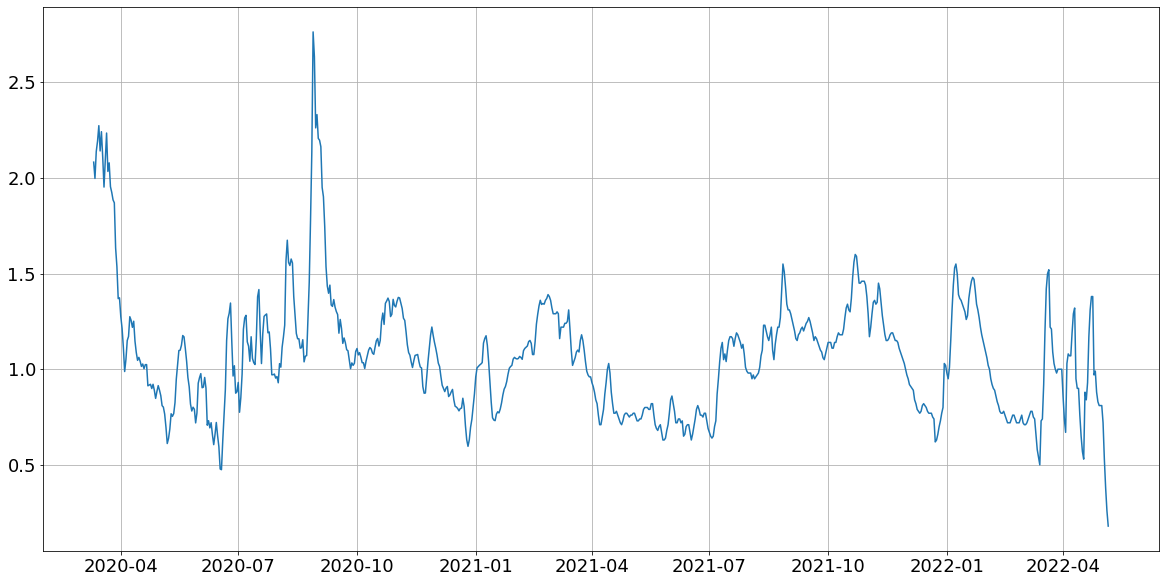

In [16]:
# test figure
plt.figure(figsize=(20,10))
plt.plot(data[data["method"]=="Cori"]["date"].map(
    lambda d: datetime.strptime(d,"%Y-%m-%d")),data[data["method"]=="Cori"]["r_eff"])
plt.grid()